In [1]:
import mlrun

In [2]:
#import sys
#!{sys.executable} -m pip install --upgrade xgboost     --quiet # upgrade boto to the latest vesion

In [3]:
project = mlrun.get_or_create_project(
    name="sagemaker-v2", 
    user_project=True,
    parameters={
        # "source" : "git://github.com/mlrun/demo-sagemaker#main",
        "default_image" : "yonishelach/sagemaker-demo"
    }
)

> 2024-02-06 08:34:06,016 [info] Project loaded successfully: {'project_name': 'sagemaker-v2'}


In [4]:
model_path = 's3://sagemaker-us-east-2-934638699319/payment-classification/output/sagemaker-xgboost-2024-02-04-15-43-54-687/output/model.tar.gz'

In [5]:
test_serving_function = project.set_function(
        func="src/functions/serving.py",
        name="test-serving",
        kind="serving",
)

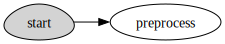

In [6]:
# Set the topology and get the graph object:
graph = test_serving_function.set_topology("flow", engine="async")

# Add the steps:
graph.to(handler="preprocess", name="preprocess").respond()

     # .to("XGBModelServer",
     #     name="xgboost-model",
     #     model_path=model_path) \
     # .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
test_serving_function.plot(rankdir='LR')

In [7]:
server = test_serving_function.to_mock_server()

In [38]:
import pandas as pd
data = pd.read_csv(
    "financial_transactions_mini.csv",
    parse_dates=["timestamp"],
    infer_datetime_format=True,
    dtype={"transaction_category": "string"},
)

In [39]:
data

,transaction_category,receiver_id,sender_id,amount,timestamp
0,Uncategorized,4518551904499919,4333582346477646,833.26,2021-03-10 19:57:42
1,Uncategorized,4518551904499919,4642413144038776,596.63,2021-02-11 17:53:32
2,Uncategorized,4274544022939522,4952665515556751,176.76,2021-02-21 18:29:32
3,Uncategorized,4518551904499919,4457298962882528,879.78,2021-04-09 16:14:19
4,Uncategorized,4601853246125220,4578126462896710,742.25,2021-04-04 15:50:16
...,...,...,...,...,...
99992,Pension and insurances,4405008355220324,4583355906735225,205.43,2021-04-20 12:23:53
99993,Pension and insurances,4300416744511335,4949240916846171,151.49,2021-03-24 19:30:18
99994,Pension and insurances,4405008355220324,4996896020767264,188.28,2021-03-08 19:51:10
99995,Pension and insurances,4262047194499006,4017367486513464,204.26,2021-02-14 23:25:07


In [50]:
data['transaction_id'] = data.reset_index().index

In [51]:
import pandas as pd
test_data = pd.read_csv(
    "test.csv"
)

In [55]:
first_event_data =  data.drop('transaction_category',axis=1)[:1].to_dict('records')
first_event_data

[{'receiver_id': 4518551904499919,
  'sender_id': 4333582346477646,
  'amount': 833.26,
  'timestamp': Timestamp('2021-03-10 19:57:42'),
  'transaction_id': 0}]

In [56]:
import mlrun.feature_store as fstore
def get_realtime_transactions_aggregations():
    # Create a feature vector that gets the average amount
    vector = fstore.FeatureVector("aggregations-vector", ["aggregations.amount_avg_1d"], with_indexes=True)
    #get the categories list
    unique_categories = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16"]
    # Use online feature service to get the latest average amount per category
    with vector.get_online_feature_service() as online_feature_service:
        resp = online_feature_service.get(
            [{"transaction_category":cat} for cat in unique_categories]
        )
    return resp


In [57]:
resp = get_realtime_transactions_aggregations()
resp

[{'amount_avg_1d': 606.79, 'transaction_category': '0'},
 {'amount_avg_1d': 17.0, 'transaction_category': '1'},
 {'amount_avg_1d': 883.925, 'transaction_category': '2'},
 {'amount_avg_1d': 128.59, 'transaction_category': '3'},
 {'amount_avg_1d': 36.695, 'transaction_category': '4'},
 {'amount_avg_1d': 115.35, 'transaction_category': '5'},
 {'amount_avg_1d': 190.425, 'transaction_category': '6'},
 {'amount_avg_1d': 35.76, 'transaction_category': '7'},
 {'amount_avg_1d': 5400.805, 'transaction_category': '8'},
 {'amount_avg_1d': 163.965, 'transaction_category': '9'},
 {'amount_avg_1d': 123.33, 'transaction_category': '10'},
 {'amount_avg_1d': 265.07500000000005, 'transaction_category': '11'},
 {'amount_avg_1d': 14.575, 'transaction_category': '12'},
 {'amount_avg_1d': 119.17, 'transaction_category': '13'},
 {'amount_avg_1d': 674.905, 'transaction_category': '14'},
 {'amount_avg_1d': 4964.49, 'transaction_category': '15'},
 {'amount_avg_1d': 166.99, 'transaction_category': '16'}]

In [58]:
def calculate_distances(resp, event):
    for cat in resp:
        transaction_category = cat['transaction_category']        
        amount_avg = cat['amount_avg_1d']
        event[0]["dist_" + transaction_category] = abs(amount_avg - event[0]["amount"])

    return event

In [59]:
dist_event = calculate_distances(resp,first_event_data)
dist_event

[{'receiver_id': 4518551904499919,
  'sender_id': 4333582346477646,
  'amount': 833.26,
  'timestamp': Timestamp('2021-03-10 19:57:42'),
  'transaction_id': 0,
  'dist_0': 226.47000000000003,
  'dist_1': 816.26,
  'dist_2': 50.664999999999964,
  'dist_3': 704.67,
  'dist_4': 796.5649999999999,
  'dist_5': 717.91,
  'dist_6': 642.835,
  'dist_7': 797.5,
  'dist_8': 4567.545,
  'dist_9': 669.295,
  'dist_10': 709.93,
  'dist_11': 568.185,
  'dist_12': 818.685,
  'dist_13': 714.09,
  'dist_14': 158.35500000000002,
  'dist_15': 4131.23,
  'dist_16': 666.27}]

In [60]:
dist_event[0]['timestamp'].year

2021

In [61]:
def convert_timestamp_to_components(event):
    event[0]["year"] = event[0]["timestamp"].year
    event[0]["month"] = event[0]["timestamp"].month
    event[0]["day"] = event[0]["timestamp"].day
    event[0]["hour"] = event[0]["timestamp"].hour
    event[0]["minute"] = event[0]["timestamp"].minute
    event[0]["second"] = event[0]["timestamp"].second
    del event[0]['timestamp']

    return event


In [62]:
extended_event = convert_timestamp_to_components(dist_event)
extended_event

[{'receiver_id': 4518551904499919,
  'sender_id': 4333582346477646,
  'amount': 833.26,
  'transaction_id': 0,
  'dist_0': 226.47000000000003,
  'dist_1': 816.26,
  'dist_2': 50.664999999999964,
  'dist_3': 704.67,
  'dist_4': 796.5649999999999,
  'dist_5': 717.91,
  'dist_6': 642.835,
  'dist_7': 797.5,
  'dist_8': 4567.545,
  'dist_9': 669.295,
  'dist_10': 709.93,
  'dist_11': 568.185,
  'dist_12': 818.685,
  'dist_13': 714.09,
  'dist_14': 158.35500000000002,
  'dist_15': 4131.23,
  'dist_16': 666.27,
  'year': 2021,
  'month': 3,
  'day': 10,
  'hour': 19,
  'minute': 57,
  'second': 42}]

In [67]:
def move_to_end(ls, key):
    """Move an item to the end of the dictionary."""
    d = ls[0]
    if key in d:
        value = d.pop(key)  # Remove the item and get its value
        d[key] = value  # Reinsert the item, which moves it to the end
    ls[0] = d
    return ls

In [68]:
restructured_event = move_to_end(extended_event,'transaction_id')
restructured_event

[{'receiver_id': 4518551904499919,
  'sender_id': 4333582346477646,
  'amount': 833.26,
  'dist_0': 226.47000000000003,
  'dist_1': 816.26,
  'dist_2': 50.664999999999964,
  'dist_3': 704.67,
  'dist_4': 796.5649999999999,
  'dist_5': 717.91,
  'dist_6': 642.835,
  'dist_7': 797.5,
  'dist_8': 4567.545,
  'dist_9': 669.295,
  'dist_10': 709.93,
  'dist_11': 568.185,
  'dist_12': 818.685,
  'dist_13': 714.09,
  'dist_14': 158.35500000000002,
  'dist_15': 4131.23,
  'dist_16': 666.27,
  'year': 2021,
  'month': 3,
  'day': 10,
  'hour': 19,
  'minute': 57,
  'second': 42,
  'transaction_id': 0}]

In [70]:
values_list = list(restructured_event[0].values())
values_list

[4518551904499919,
 4333582346477646,
 833.26,
 226.47000000000003,
 816.26,
 50.664999999999964,
 704.67,
 796.5649999999999,
 717.91,
 642.835,
 797.5,
 4567.545,
 669.295,
 709.93,
 568.185,
 818.685,
 714.09,
 158.35500000000002,
 4131.23,
 666.27,
 2021,
 3,
 10,
 19,
 57,
 42,
 0]

In [71]:
return_list = [values_list]
return_list

[[4518551904499919,
  4333582346477646,
  833.26,
  226.47000000000003,
  816.26,
  50.664999999999964,
  704.67,
  796.5649999999999,
  717.91,
  642.835,
  797.5,
  4567.545,
  669.295,
  709.93,
  568.185,
  818.685,
  714.09,
  158.35500000000002,
  4131.23,
  666.27,
  2021,
  3,
  10,
  19,
  57,
  42,
  0]]

In [15]:
samples = test_data.drop('transaction_category',axis=1)[:1].values.tolist()
samples

[[4572835609402945.0,
  4036699444587678.5,
  1936.83,
  1417.285,
  1883.725,
  1838.2753142857143,
  1517.5099999999998,
  1917.2477777777776,
  1688.4639999999995,
  1418.1149999999975,
  1324.3757142857137,
  1506.1275,
  1081.8533333333314,
  1725.5830000000003,
  1936.83,
  1834.4686689419796,
  1900.4391666666663,
  1805.5211627906972,
  1844.352278481013,
  1884.5990322580644,
  5144.063333333338,
  1844.468,
  2021.0,
  2.0,
  24.0,
  2.0,
  13.0,
  10.0,
  44990.0]]

In [ ]:
import pandas as pd
response = server.test(body=samp_dict)

In [ ]:
# import pandas as pd
# response = server.test(body=samples)

In [ ]:
print(response)

In [ ]:
unique_categories = [         'Uncategorized',          'Entertainment',              'Education',
               'Shopping',          'Personal Care',     'Health and Fitness',
        'Food and Dining',    'Gifts and Donations',            'Investments',
    'Bills and Utilities',     'Auto and Transport',                 'Travel',
       'Fees and Charges',      'Business Services',      'Personal Services',
                  'Taxes',               'Gambling',                   'Home',
 'Pension and insurances']

In [ ]:
len('unique_categories')

In [ ]:
# Define the list of features we will be using
features = ['aggregations.*']

# Import MLRun's Feature Store
import mlrun.feature_store as fstore

# Define the feature vector name for future reference
fv_name = 'aggregations-vector'

# Define the feature vector using our Feature Store (fstore)
aggregations_fv = fstore.FeatureVector(fv_name, 
                          features, 
                          description='aggregation information')

# Save the feature vector in the Feature Store
aggregations_fv.save()

In [ ]:
import mlrun.feature_store as fstore

# Create a feature vector that gets the average amount
vector = fstore.FeatureVector("transactions_vector", ["aggregations.amount_avg_1d"], with_indexes=True)
unique_categories = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16"]
# Use online feature service to get the latest average amount per category
with vector.get_online_feature_service() as online_feature_service:
    resp = online_feature_service.get(
        [{"transaction_category":cat} for cat in unique_categories]
    )

In [ ]:
print(resp)

In [ ]:
for cat in resp:
    transaction_category = cat['transaction_category']
    amount_avg = cat['amount_avg_1d']
    data["dist_" + transaction_category] = abs(amount_avg - data["amount"])